In [1]:
include("src\\ImportanceSampling.jl")
using Distributions
using ImportanceSampling
using Seaborn

In [2]:
srand(2^10);

In [3]:
function gen_w_normal(μ0::Vector{<:Real}, μ::Vector{<:Real}, Σ::Matrix{<:Real})
    invΣ = inv(Σ)
    dη = invΣ*(μ0-μ)
    C = exp(1/2*( dot(μ, invΣ*μ) - dot(μ0, invΣ*μ0) ))
    return (x::AbstractVector{<:Real}) -> C*exp(dot(x, dη))
end

f!(r, x) = r .= x

m0s = -3.5:0.5:3.5
nmeans = length(m0s)
q = Normal()
ws = [gen_w_normal([m0], zeros(1), eye(1)) for m0 in m0s]

ntrials = 50
niters = 10_000
;

In [4]:
X = zeros(1, niters)
iss = Matrix(ntrials, nmeans)

for tr in 1:ntrials
    rand!(q, X)
    
    for i in 1:nmeans
        iss[tr, i] = ImportanceSampler(f!, 2, q, w=ws[i])
        update!(iss[tr, i]; X=X)
    end
end

In [5]:
ms = first.(mean.(iss))
vs = first.(var.(iss))
ms_avg = vec(mean(ms, 1))
vs_avg = vec(mean(vs, 1))
est_v = vec(var(ms, 1))

nes = ne.(iss)
neσs = neσ.(iss)
nes_avg = vec(mean(nes, 1))
neσs_avg = vec(mean(neσs, 1))
;

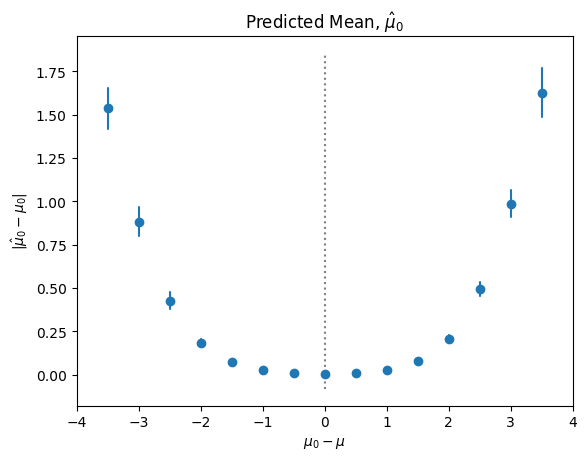

C:\Anaconda3\envs\conda_jl\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


In [6]:
tsplot(abs.(ms.-m0s'), m0s, err_style="ci_bars", interpolate=false)
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Predicted Mean, " * L"\hat \mu_0")
xlabel(L"\mu_0 - \mu")
ylabel(L"|\hat \mu_0 - \mu_0|")
savefig("../img/normal_mean.png", bbox_inches="tight")
;

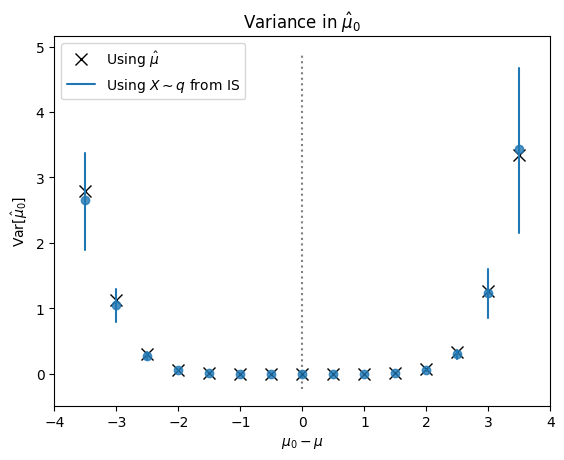

In [7]:
plot(m0s, est_v, "kx", ms="9")
tsplot(vs, m0s, err_style="ci_bars", interpolate=false, alpha=0.8)
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Variance in " * L"\hat \mu_0")
xlabel(L"\mu_0 - \mu")
ylabel(L"\mathrm{Var}[\hat \mu_0]")
legend(["Using " * L"\hat \mu", "Using " * L"X \sim q" * " from IS"])
savefig("../img/normal_var.png", bbox_inches="tight")

;

In [8]:
m = zeros(1)
Σ = eye(1)
Λ = inv(1)
m0s_pred = linspace(first(m0s), last(m0s), 100)
nes_pred = niters * [exp(dot(m0, Λ*m0) - 1/2*dot(m, Λ*m)-1/2*dot(2*m0-m, Λ*(2*m0-m))) for m0 in m0s_pred];

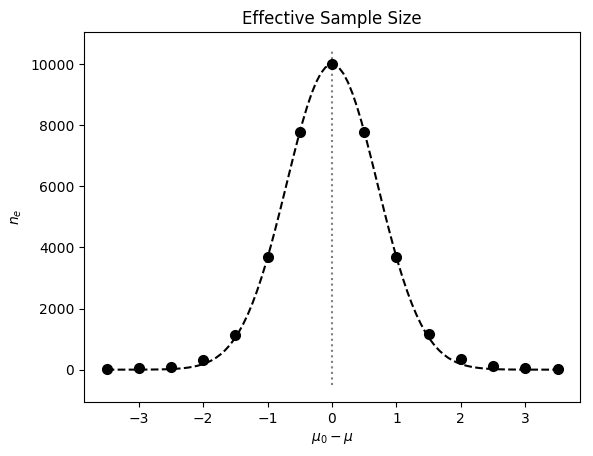

In [9]:
plot(m0s_pred, nes_pred, "--k") 
plot(m0s, nes_avg, "ko", ms=7)
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Effective Sample Size")
xlabel(L"\mu_0 - \mu")
ylabel(L"n_e")
savefig("../img/normal_ne.png", bbox_inches="tight")
;

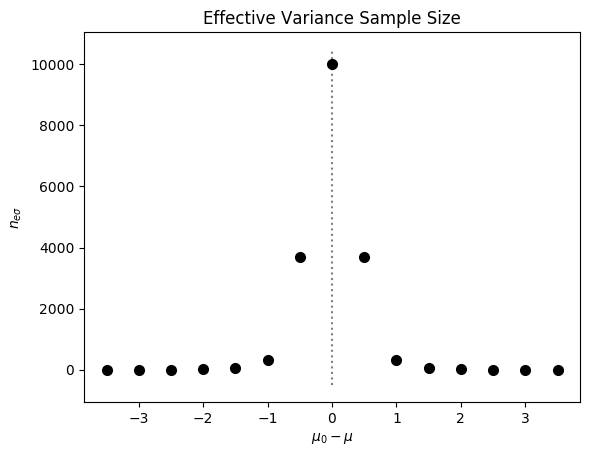

In [10]:
plot(m0s, neσs_avg, "ko", ms=7)
vlines(0, ylim()..., color="grey", linestyle="dotted")
title("Effective Variance Sample Size")
xlabel(L"\mu_0 - \mu")
ylabel(L"n_{e\sigma}")
savefig("../img/normal_nesigma.png", bbox_inches="tight")
;